In [1]:
# !pip install transformers accelerate datasets git+https://github.com/huggingface/diffusers Pillow==9.4.0 torchmetrics wandb

In [2]:
from local_secrets import hf_token, wandb_key
from huggingface_hub import login
import wandb

login(token=hf_token)
wandb.login(key=wandb_key)

wandb: Currently logged in as: g-ronimo. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import torch, torch.nn.functional as F, random, wandb, time
import torchvision.transforms as T
from diffusers import AutoencoderDC, SanaTransformer2DModel
from diffusers.schedulers import FlowMatchEulerDiscreteScheduler
from transformers import AutoModel, AutoTokenizer, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from tqdm import tqdm

from utils import PIL_to_latent, latent_to_PIL, make_grid, encode_prompt, dcae_scalingf, pil_clipscore

seed = 42
set_seed(seed)

In [4]:
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

transformer = SanaTransformer2DModel.from_config("transformer_Sana-7L-MBERT_config.json").to(device).to(dtype)
text_encoder = AutoModel.from_pretrained("answerdotai/ModernBERT-base", torch_dtype=dtype).to(device)
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base", torch_dtype=dtype)

model = "Efficient-Large-Model/Sana_600M_1024px_diffusers"
dcae = AutoencoderDC.from_pretrained(model, subfolder="vae", torch_dtype=dtype).to(device)

scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(model, subfolder="scheduler")

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.load_config(...) followed by <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
Process ForkProcess-23:
Process ForkProcess-22:
Process ForkProcess-1:
Process ForkProcess-26:
Process ForkProcess-27:
Process ForkProcess-31:
Process ForkProcess-20:
Process ForkProcess-30:
Process ForkProcess-3:
Process ForkProcess-2:
Process ForkProcess-32:
Process ForkProcess-24:
Process ForkProcess-9:
Process ForkProcess-7:
Process ForkProcess-18:
Process Fo

# Load dataset

In [5]:
from utils import fmnist_labels

In [6]:
ds = load_dataset("g-ronimo/FMNIST-latents-64_dc-ae-f32c32-sana-1.0")
labels = fmnist_labels
labels_encoded={k: encode_prompt(labels[k], tokenizer, text_encoder) for k in labels}

len(labels_encoded), len(labels_encoded[0]), labels_encoded[0][0].shape, labels_encoded[0][1].shape

/usr/local/lib/python3.10/dist-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


(10, 2, torch.Size([1, 300, 768]), torch.Size([1, 300]))

In [7]:
ds.keys()

dict_keys(['train', 'test'])

In [8]:
from torch.utils.data import DataLoader

def collate(items):
    labels = [i["label"] for i in items]
    latents = torch.cat([torch.Tensor(i["latent"]) for i in items]).to(dtype).to(device)
    prompts_encoded = torch.cat([labels_encoded[label][0] for label in labels])
    prompts_atnmask = torch.cat([labels_encoded[label][1] for label in labels])

    return labels, latents, prompts_encoded, prompts_atnmask

dataloader = DataLoader(ds["train"], batch_size=2, shuffle=True, generator = torch.manual_seed(seed), collate_fn=collate)
labels, latents, prompts_encoded, prompts_atnmask = next(iter(dataloader))
len(labels), latents.mean(), latents.shape, prompts_encoded.shape, prompts_atnmask.shape

(2,
 tensor(0.1982, device='cuda:0', dtype=torch.bfloat16),
 torch.Size([2, 32, 2, 2]),
 torch.Size([2, 300, 768]),
 torch.Size([2, 300]))

# Helpers for eval and generate

In [9]:
def generate(prompt, num_timesteps=10, latent_dim=[1, 32, 2, 2], latent_seed=42):
    scheduler.set_timesteps(num_timesteps)
    prompt_encoded, prompt_atnmask = encode_prompt(prompt, tokenizer, text_encoder)
    latents = torch.randn(latent_dim, generator = torch.manual_seed(latent_seed)).to(dtype).to(device)

    for t_idx in range(num_timesteps):
        t = scheduler.timesteps[t_idx].unsqueeze(0).to(device)
        with torch.no_grad():
            noise_pred = transformer(latents, encoder_hidden_states=prompt_encoded, timestep=t, encoder_attention_mask=prompt_atnmask, return_dict=False)[0]
        latents = scheduler.step(noise_pred, t, latents, return_dict=False)[0]
    return latent_to_PIL(latents / dcae_scalingf, dcae)

[generate("0")]

[<PIL.Image.Image image mode=RGB size=64x64>]

In [10]:
def eval_loss(data_val, num_samples=10, num_timesteps=10, batch_size=24):
    losses = []
    eval_dataloader = iter(DataLoader(data_val, batch_size=batch_size, shuffle=False, collate_fn=collate))

    for i in tqdm(range(num_samples), "eval_loss"):
        label, latent, prompt_encoded, prompt_atnmask = next(eval_dataloader)
        noise = torch.randn_like(latent)
        timestep = scheduler.timesteps[[random.randint(0, num_timesteps-1) for _ in range(batch_size)]].to(device)
        latent_noisy = scheduler.scale_noise(latent, timestep, noise)
        with torch.no_grad():
            noise_pred = transformer(latent_noisy, encoder_hidden_states = prompt_encoded, encoder_attention_mask = prompt_atnmask, timestep = timestep, return_dict=False)[0]
        loss = F.mse_loss(noise_pred, noise - latent)
        losses.append(loss.item())
    return sum(losses)/len(losses)

eval_loss(ds["train"])

eval_loss: 100%|██████████| 10/10 [00:00<00:00, 28.81it/s]


11.70625

In [11]:
def eval_clipscore(seeds=[1,7,42]):
    prompts = [fmnist_labels[k] for k in fmnist_labels]
    images = [generate(p, latent_seed=seed) for seed in tqdm(seeds, "eval_clipscore") for p in prompts]
    return pil_clipscore(images, prompts*len(seeds))

eval_clipscore()

eval_clipscore: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


21.874094009399414

# Train

In [12]:
log_wandb = True
lr = 5e-4
# bs = 128
bs = 896
epochs = 400
diffuser_timesteps = 10
steps_log, steps_eval = 20, 200
# steps_log, steps_eval = 2, 10

splits = list(ds.keys())
data_train, data_val = ds[splits[0]], ds[splits[1]]

steps_epoch = len(data_train) // bs

dataloader = DataLoader(data_train, batch_size=bs, shuffle=True, generator = torch.manual_seed(seed), collate_fn=collate)
optimizer = torch.optim.AdamW(transformer.parameters(), lr=lr)
scheduler.set_timesteps(diffuser_timesteps)

model_size = sum(p.numel() for p in transformer.parameters() if p.requires_grad)
print(f"Model parameters: {model_size / 1e6:.2f}M")
print(f"{len(splits)} splits: {splits}", [len(ds[s]) for s in splits])
assert len(splits)==2 

Model parameters: 156.41M
2 splits: ['train', 'test'] [60000, 10000]


step 0, epoch: 0.0000, train loss: 11.5625, grad_norm: 23.75, 43.23ms/step, 20727.03samples/sec


eval_images: 100%|██████████| 10/10 [00:00<00:00, 12.42it/s]

step 0, eval loss: 10.9812, clipscore: 21.85


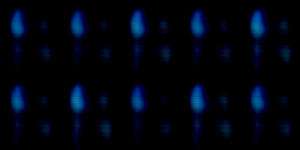

step 20, epoch: 0.3030, train loss: 3.4531, grad_norm: 2.75, 929.17ms/step, 964.30samples/sec
step 40, epoch: 0.6061, train loss: 2.6406, grad_norm: 1.59, 538.17ms/step, 1664.90samples/sec
step 60, epoch: 0.9091, train loss: 2.3438, grad_norm: 1.20, 537.91ms/step, 1665.69samples/sec
step 80, epoch: 1.2121, train loss: 2.1562, grad_norm: 1.43, 541.72ms/step, 1654.00samples/sec
step 100, epoch: 1.5152, train loss: 2.0469, grad_norm: 1.20, 540.17ms/step, 1658.72samples/sec
step 120, epoch: 1.8182, train loss: 1.9766, grad_norm: 1.24, 535.26ms/step, 1673.96samples/sec
step 140, epoch: 2.1212, train loss: 1.9531, grad_norm: 0.95, 529.22ms/step, 1693.05samples/sec
step 160, epoch: 2.4242, train loss: 1.9062, grad_norm: 1.10, 531.16ms/step, 1686.86samples/sec
step 180, epoch: 2.7273, train loss: 1.9453, grad_norm: 0.96, 547.93ms/step, 1635.24samples/sec
step 200, epoch: 3.0303, train loss: 1.8516, grad_norm: 0.95, 535.99ms/step, 1671.69samples/sec


eval_images: 100%|██████████| 10/10 [00:00<00:00, 11.43it/s]

step 200, eval loss: 1.7047, clipscore: 23.23


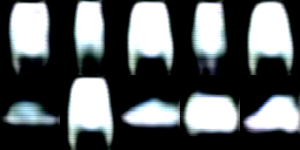

step 220, epoch: 3.3333, train loss: 1.9062, grad_norm: 0.90, 942.79ms/step, 950.37samples/sec
step 240, epoch: 3.6364, train loss: 1.8906, grad_norm: 0.79, 537.49ms/step, 1667.00samples/sec
step 260, epoch: 3.9394, train loss: 1.8203, grad_norm: 0.71, 532.83ms/step, 1681.59samples/sec
step 280, epoch: 4.2424, train loss: 1.8203, grad_norm: 0.75, 528.08ms/step, 1696.70samples/sec
step 300, epoch: 4.5455, train loss: 1.8359, grad_norm: 0.87, 542.39ms/step, 1651.96samples/sec
step 320, epoch: 4.8485, train loss: 1.8125, grad_norm: 0.68, 538.67ms/step, 1663.36samples/sec
step 340, epoch: 5.1515, train loss: 1.8047, grad_norm: 0.68, 541.65ms/step, 1654.21samples/sec
step 360, epoch: 5.4545, train loss: 1.8438, grad_norm: 0.66, 530.46ms/step, 1689.11samples/sec
step 380, epoch: 5.7576, train loss: 1.7891, grad_norm: 0.70, 541.49ms/step, 1654.68samples/sec
step 400, epoch: 6.0606, train loss: 1.8047, grad_norm: 0.67, 546.03ms/step, 1640.93samples/sec


eval_images: 100%|██████████| 10/10 [00:00<00:00, 11.24it/s]

step 400, eval loss: 1.6852, clipscore: 23.16


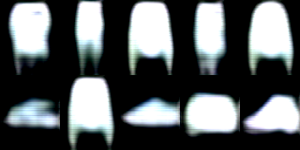

KeyboardInterrupt: 

In [13]:
if log_wandb: 
    if wandb.run is not None: wandb.finish()
    wandb.init(project="Hana", name=f"Z-{model_size / 1e6:.2f}M_FMNIST_LR-{lr}_BS-{bs}_10-runpod4090").log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb") or path.endswith(".json"))

step = 0
last_step_time = time.time()

for _ in range(epochs):
    for labels, latents, prompts_encoded, prompts_atnmask in dataloader:        
        noise = torch.randn_like(latents)
        timesteps = scheduler.timesteps[torch.randint(diffuser_timesteps,(latents.shape[0],))].to(device)
        latents_noisy = scheduler.scale_noise(latents, timesteps, noise)        
        noise_pred = transformer(latents_noisy, prompts_encoded, timesteps, prompts_atnmask).sample
    
        loss = F.mse_loss(noise_pred, noise - latents)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()        
        
        if step % steps_log == 0:
            loss_train = loss.item()
            step_time = (time.time() - last_step_time) / steps_log * 1000
            sample_tp = bs * steps_log / (time.time() - last_step_time)
            print(f"step {step}, epoch: {step / steps_epoch:.4f}, train loss: {loss_train:.4f}, grad_norm: {grad_norm:.2f}, {step_time:.2f}ms/step, {sample_tp:.2f}samples/sec")
            if log_wandb: wandb.log({"loss_train": loss_train, "grad_norm": grad_norm, "step_time": step_time, "step": step, "sample_tp": sample_tp, "sample_count": step * bs, "epoch": step / steps_epoch})
            last_step_time = time.time()
    
        if step % steps_eval == 0:
            transformer.eval()
            loss_eval, clipscore, images_eval = eval_loss(data_val), eval_clipscore(), make_grid([generate(p) for p in tqdm([fmnist_labels[k] for k in fmnist_labels], "eval_images")], 2, 5)
            print(f"step {step}, eval loss: {loss_eval:.4f}, clipscore: {clipscore:.2f}")
            if log_wandb: wandb.log({"loss_eval": loss_eval, "clipscore": clipscore, "images_eval": wandb.Image(images_eval), "step": step, "sample_count": step * bs, "epoch": step / steps_epoch})
            else: display(images_eval.resize((300,150)))
            transformer.train()
        step += 1

In [ ]:
transformer.push_to_hub(f"g-ronimo/hana-small_alpha8-400e")

In [ ]:
# !runpodctl remove pod $RUNPOD_POD_ID